# Imports

In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest

# Constants

In [89]:
# Data generation
SAMPLE_TRAIN_SIZE = 100
SAMPLE_TEST_SIZE = 5
SAMPLE_OUTLIER_SIZE = 5

# Generalized Deduplication
DEVIATION_BITS = 2

# Load data

In [90]:
rng = np.random.RandomState(42)

# Generate train data
X_train = np.r_[(
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 60, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50)],
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)],
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)]
)]

# Generate test data
X_test = np.r_[(
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 60, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50)],
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)],
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)]
)]

# Generate outliers
X_outliers = np.r_[
    (np.c_[(rng.uniform(low=40, high=60, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=70, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))],
     np.c_[(rng.uniform(low=65, high=120, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=60, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))]
     )]
X_outliers = X_outliers.astype(int)

## Plot train, test and outliers in scatter plot

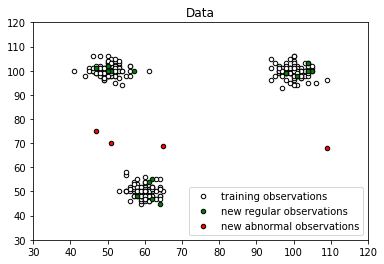

In [91]:
plt.title("Data")
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="lower right",
)
plt.show()

## Perform Generalized Deduplication

In [92]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")

X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

X_outliers_bases = vectorized_func(X_outliers, deviation_bits=DEVIATION_BITS, output="integer")


## Plot train, test and outliers after generalized deduplication in scatter plot

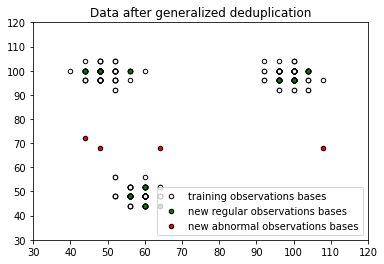

In [93]:
plt.title("Data after generalized deduplication")
b1 = plt.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations bases", "new regular observations bases", "new abnormal observations bases"],
    loc="lower right",
)
plt.show()

<AxesSubplot:ylabel='Density'>

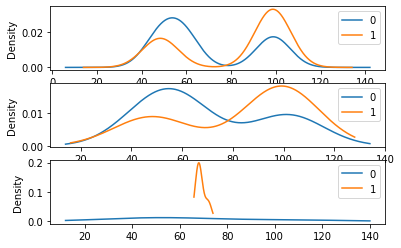

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
pd.DataFrame(X_outliers_bases).plot.density(ax=axes[2])

## Isolation Forest

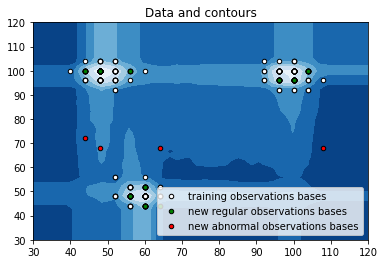

,X,Y,score,anomaly
0,60,44,-0.040309,-1
1,60,48,0.068035,1
2,60,48,0.068035,1
3,64,48,-0.101989,-1
4,60,48,0.068035,1


In [95]:
clf = IsolationForest(random_state=rng)
clf.fit(X_train_bases)

y_pred_train = clf.predict(X_train_bases)
y_pred_test = clf.predict(X_test_bases)
y_pred_outliers = clf.predict(X_outliers_bases)

xx, yy = np.meshgrid(np.linspace(30, 120, 50), np.linspace(30, 120, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Data and contours")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations bases", "new regular observations bases", "new abnormal observations bases"],
    loc="lower right",
)
plt.show()

df_results = pd.DataFrame()
df_results['X'] = X_train_bases[:,0]
df_results['Y'] = X_train_bases[:,1]
df_results['score'] = clf.decision_function(X_train_bases)
df_results['anomaly'] = clf.predict(X_train_bases)
df_results.head()

## Calculations

### Count amount of base occurences

In [96]:
array = X_train_bases#your numpy array of lists
new_array = [tuple(row) for row in array]
unique, idx, counts = np.unique(new_array, axis=0, return_index=True, return_counts=True)

df_unique = pd.DataFrame()
df_unique['X'] = unique[:,0]
df_unique['Y'] = unique[:,1]
df_unique['counts'] = counts
df_unique['org_idx'] = idx
df_unique.head()

,X,Y,counts,org_idx
0,40,100,1,162
1,44,96,4,136
2,44,100,9,104
3,44,104,1,123
4,48,96,19,100


### Prepare data for calculation

In [97]:
# Convert sklearn score range to paper score range [-0.5;0.5] -> [0;1]
df_results['score'] = df_results['score'].sub(0.5).mul(-1)
df_results.head()

# Add score and anomaly to df_uniques
scores = []
anomaly = []
for index, row in df_unique.iterrows():
    result = df_results[(df_results.X == row.X) & (df_results.Y == row.Y)].iloc[0]
    scores.append(result.score)
    anomaly.append(result.anomaly)

df_unique['anomaly'] = anomaly
df_unique['score'] = scores

# Define constants
n_samples = len(df_results)
n_uniques = len(df_unique)
df_unique.head()

,X,Y,counts,org_idx,anomaly,score
0,40,100,1,162,-1.0,0.678488
1,44,96,4,136,-1.0,0.591862
2,44,100,9,104,1.0,0.497848
3,44,104,1,123,-1.0,0.655464
4,48,96,19,100,1.0,0.455136


### Perform calculation

In [98]:
def H(i):
    return np.log(i) + 0.5772156649 # euler's constant

def c(n):
    return 2*H(n-1) - ((2*(n-1))/n)


Calculation 1:  $\log_2(s(x,n)) \cdot c(n) = E(h(x))$

In [99]:
result = []
for index, row in df_unique.iterrows():
    res = -(np.log2(row.score) * c(n_samples)) + np.log2(row.counts)
    result.append(res)
df_unique['E[H(x)]+log_2[count(x)]'] = result
df_unique

,X,Y,counts,org_idx,anomaly,score,E[H(x)]+log_2[count(x)]
0,40,100,1,162,-1.0,0.678488,5.910529
1,44,96,4,136,-1.0,0.591862,9.991919
2,44,100,9,104,1.0,0.497848,13.797645
3,44,104,1,123,-1.0,0.655464,6.436591
4,48,96,19,100,1.0,0.455136,16.242446
5,48,100,34,105,1.0,0.408854,18.716058
6,48,104,5,161,-1.0,0.563410,11.064540
7,52,48,4,14,-1.0,0.640062,8.798925
8,52,56,2,13,-1.0,0.686151,6.739408
9,52,92,2,182,-1.0,0.653729,7.476976


Calculation 2: $S(x, n_{samples})=2^{-\frac{E(h(x))}{c(n_{samples})}}$

In [100]:
result = []
for index, row in df_unique.iterrows():
    res = 2 ** - (row['E[H(x)]+log_2[count(x)]'] / c(n_samples))
    result.append(res)
df_unique['S(x,n_samples)'] = result
df_unique.head()

,X,Y,counts,org_idx,anomaly,score,E[H(x)]+log_2[count(x)],"S(x,n_samples)"
0,40,100,1,162,-1.0,0.678488,5.910529,0.678488
1,44,96,4,136,-1.0,0.591862,9.991919,0.519060
2,44,100,9,104,1.0,0.497848,13.797645,0.404343
3,44,104,1,123,-1.0,0.655464,6.436591,0.655464
4,48,96,19,100,1.0,0.455136,16.242446,0.344405


# Data Visualization

## Score Scatter

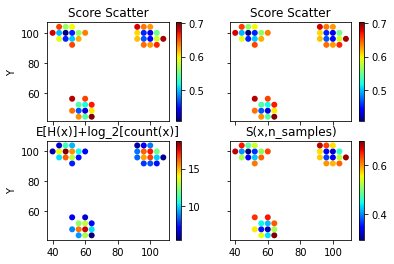

In [102]:
fig, axs = plt.subplots(2, 2)
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

points = ax1.scatter(df_unique.X, df_unique.Y, c=df_unique.score,cmap="jet", lw=0)
plt.colorbar(points,ax=ax1)
ax1.set_title("Score Scatter")

points = ax2.scatter(df_unique.X, df_unique.Y, c=df_unique.score,cmap="jet", lw=0)
plt.colorbar(points,ax=ax2)
ax2.set_title("Score Scatter")

points = ax3.scatter(df_unique.X, df_unique.Y, c=df_unique['E[H(x)]+log_2[count(x)]'],cmap="jet", lw=0)
plt.colorbar(points,ax=ax3)
ax3.set_title("E[H(x)]+log_2[count(x)]")

points = ax4.scatter(df_unique.X, df_unique.Y, c=df_unique['S(x,n_samples)'],cmap="jet", lw=0)
plt.colorbar(points,ax=ax4)
ax4.set_title("S(x,n_samples)")

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax2.set_yticklabels([])
ax4.set_yticklabels([])

ax3.set_ylabel('Y')
ax1.set_ylabel('Y')
plt.show()

## Definitions

$n$: number of samples

$c(n)$: average path length of unsuccessfull search - constant given n

$H(i)$: harmonic number - estimated by $ln(i) + e$

$h(x)$: path length - number of edges x traverses an itree from the root node

$n$: amount of instances/nodes - amount of bases in our situation

$s$: anomaly score -
$s(x,n)=2^{\frac{-E(h(x))}{c(n)}}$

$E(h(x))$: average of $h(x)$ from a collection of isolation trees.

$f_{base}=\log_2(n_{base})$

---

## Deriving equations
1:

$\log_2(s) \cdot c(n)=-E(h(x))$

2:

$\log_2(s)=-\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$

3:

$\log_2(s) \cdot c(n) = -E(h(x))$

4:

$\log_2(s) = -\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$


---


